
# Undersampling k-space: KKI model
Deep learning for undersampled MRI reconstruction
- **Author**: Georgia Kanli
- **Date**: 01/09/2023
- **Purpose**: 2D-Unet - KI 
    - The deep learning model includes 2 components: (1): Under-sampling correction model in k-space domain (2): artefacts correction model in image domain

# **1. Import libraries**

In [1]:
import tensorflow as tf
tf.__version__


2024-10-31 08:00:22.937046: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 08:00:22.958145: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-31 08:00:23.964812: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.13.0'

In [2]:
# %reset -f
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
path_start = 'mainFolder/'
sys.path.append(path_start)


import json
import os
import numpy as np

from utils.utilsFun import open_json
from mainFolder.main import run
from mainFolder.dataGeneratorUtils import load_net_partition
    

/home/gkanli/miniconda3/envs/py3.10-tensorflow/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

# Input parameters

In [4]:
json_path =  'results/Knet/configs.json'
configs = open_json(json_path)
with open(json_path, 'w') as jsonFile:
    json.dump(configs, jsonFile)
configs = open_json(json_path)
# print(configs)

path_orig_data =  "data/6000cases/" #"Add your data path"
configs.data_folder_id = path_orig_data

print(configs.us_type)
print()
configs.ID = "Inet"

configs.num_epochs = 150 #150
configs.batch_size = 16

with open(json_path, 'w') as jsonFile:
    json.dump(configs, jsonFile)
    

gradient



Data

data/6000cases/
Load partition
Load partition:data/6000cases/
{'test': ['2446-28836-3', '2446-28836-7', '2446-28836-10', '2446-28836-14', '2446-28836-15', '2446-28836-6', '2446-28836-8', '2446-28836-13', '2446-28836-4', '2446-28836-5', '2446-28836-9', '2446-28836-12', '2447-28987-11', '2447-28987-15', '2447-28987-3', '2447-28987-7', '2447-28987-2', '2447-28987-6', '2447-28987-10', '2447-28987-14', '2447-28987-4', '2447-28987-8', '2447-28987-12', '2447-28987-9', '2447-28987-13', '2447-28987-1', '2447-28987-5', '2455-28863-7', '2455-28863-13', '2455-28863-3', '2455-29286-5', '2455-29286-9', '2455-29286-8', '2455-29286-11', '2455-28863-6', '2455-28863-12', '2455-29286-4', '2455-29286-13', '2455-28863-8', '2455-28863-4', '2455-28863-10', '2455-29286-6', '2455-28863-5', '2455-28863-11', '2455-29286-3', '2455-29286-7', '2455-29286-12', '2455-28863-9', '2456-28861-12', '2456-28861-13', '2456-28861-6', '2456-28861-11', '2456-28861-15', '2456-28861-8', '2456-28861-9', '2456-28861-10', '2456-288

([], [])

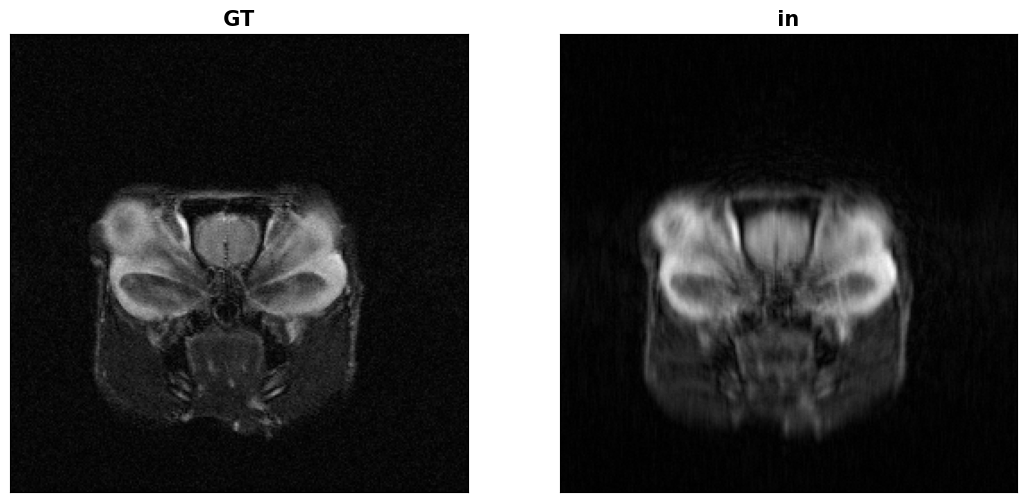

In [5]:

import matplotlib.pyplot as plt
import MRDLin
i = 0
path = configs.data_folder_id
print(path)
print('Load partition')
partition = load_net_partition(path)  
partition = partition.item()      

print(partition)
name_y = configs.main_data_folder + configs.full_ks + partition['test'][i] + '.npy'
print(name_y)
y_i = np.load(name_y)
y_i = np.resize(y_i, (configs.img_size, configs.img_size))

name_x = configs.output_dir_base + "Knet/NextNet/" + partition['test'][i] + '.npy'
x_i = np.load(name_x)
print(name_x)
x_i = np.resize(x_i, (configs.img_size, configs.img_size))
# normalize
min = np.min(x_i)
max = np.max(x_i)
x_i = (x_i-min)/(max-min)

# GT
y_it = abs(MRDLin.recon_corrected_kspace(y_i))
# normalize
min = np.min(y_it)
max = np.max(y_it)
y_out = (y_it-min)/(max-min)
            
    
fig = plt.figure(figsize=(13, 13))        
# k-space domain
plt.subplot(1, 2, 1)
plt.imshow(y_out, cmap='gray')
plt.title(' GT ', fontweight="bold", fontsize=15)
plt.xticks([])
plt.yticks([])


plt.subplot(1, 2, 2)
plt.imshow(x_i, cmap='gray')
plt.title(' in ', fontweight="bold", fontsize=15)
plt.xticks([])
plt.yticks([])


# KI models

In [6]:
import gc
tf.random.set_seed(1)


In [7]:

gc.collect()
print('********************************************************** Inet 0 ')
configs.ks_domain = "False"
configs.model = "2DUnet" # 2DUnet-leakyReLU, 2DUnet, 2DUnet-tanh or complex_cnn
configs.loss = "mssim" # "mssim" "fmssim" "mssim"  "fmse"
configs.data_folder_id = path_orig_data 
configs.us_type = "gradient"

with open(json_path, 'w') as jsonFile:
    json.dump(configs, jsonFile)
    
run(configs)

gc.collect()


********************************************************** Inet 0 
data/6000cases/
Load partition
Load partition:data/6000cases/
{'test': ['2446-28836-3', '2446-28836-7', '2446-28836-10', '2446-28836-14', '2446-28836-15', '2446-28836-6', '2446-28836-8', '2446-28836-13', '2446-28836-4', '2446-28836-5', '2446-28836-9', '2446-28836-12', '2447-28987-11', '2447-28987-15', '2447-28987-3', '2447-28987-7', '2447-28987-2', '2447-28987-6', '2447-28987-10', '2447-28987-14', '2447-28987-4', '2447-28987-8', '2447-28987-12', '2447-28987-9', '2447-28987-13', '2447-28987-1', '2447-28987-5', '2455-28863-7', '2455-28863-13', '2455-28863-3', '2455-29286-5', '2455-29286-9', '2455-29286-8', '2455-29286-11', '2455-28863-6', '2455-28863-12', '2455-29286-4', '2455-29286-13', '2455-28863-8', '2455-28863-4', '2455-28863-10', '2455-29286-6', '2455-28863-5', '2455-28863-11', '2455-29286-3', '2455-29286-7', '2455-29286-12', '2455-28863-9', '2456-28861-12', '2456-28861-13', '2456-28861-6', '2456-28861-11', '2456-28

2024-10-31 08:27:04.259167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-31 08:27:04.271480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-31 08:27:04.271562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

************************************
functools.partial(<function compound_l1_mssim_loss at 0x7f86d3566680>)
************************************
ModelGenerator: Create the callbacks_out ... 
results//Inet/model_per_epoch/
ModelGenerator: Training ... 
Epoch 1/150


2024-10-31 08:27:07.434535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-10-31 08:27:07.796277: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-31 08:27:08.547286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


625/625 [==============================] - ETA: 0s - loss: 0.0709 - mse: 5.1630e-06 - ssim: 0.1270

/home/gkanli/miniconda3/envs/py3.10-tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 45s 67ms/step - loss: 0.0709 - mse: 5.1630e-06 - ssim: 0.1270 - val_loss: 0.0534 - val_mse: 2.5144e-06 - val_ssim: 0.1672 - lr: 1.0000e-04
Epoch 2/150
625/625 [==============================] - 42s 66ms/step - loss: 0.0513 - mse: 1.8757e-06 - ssim: 0.1693 - val_loss: 0.0516 - val_mse: 2.4164e-06 - val_ssim: 0.1818 - lr: 1.0000e-04
Epoch 3/150
625/625 [==============================] - 42s 67ms/step - loss: 0.0498 - mse: 1.8050e-06 - ssim: 0.1786 - val_loss: 0.0506 - val_mse: 2.3536e-06 - val_ssim: 0.1872 - lr: 1.0000e-04
Epoch 4/150
625/625 [==============================] - 42s 66ms/step - loss: 0.0490 - mse: 1.7689e-06 - ssim: 0.1827 - val_loss: 0.0496 - val_mse: 2.2582e-06 - val_ssim: 0.1937 - lr: 1.0000e-04
Epoch 5/150
625/625 [==============================] - 42s 67ms/step - loss: 0.0484 - mse: 1.7407e-06 - ssim: 0.1855 - val_loss: 0.0491 - val_mse: 2.2051e-06 - val_ssim: 0.1960 - lr: 1.0000e-04
Epoch 6/150
625/625 [=====================

5249